# Discovering the number of events

We usually do not have precise enough information to decide a priori on a number of events that an HMP model should have. To illustrate the problem let's use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper. For the purpose of this tutorial we will only use the last four participants of the data (see [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper for the method and [https://osf.io/pd3kf/](https://osf.io/pd3kf/) for the whole (unpreprocessed) data).

In this experiment, participants performed a random-dot motion task. They were asked to indicate the direction of motion of a cloud of moving dots. While a proportion of the dots moved in a target direction, the remainder moved randomly and makes the direction discrimination more difficult. Difficulty of the task was calibrated per subject. Prior to each trial, participants received a cue that indicated whether they should respond as quickly as possible or whether they should focus on giving an accurate response: the 'speed' and 'accuracy' conditions. In this tutorial we will ignore the difference between these conditions, but in the next tutorial we will look at how we can take conditions into account in the HMP analysis.

In this tutorial we will look at three different ways to discover and test the number of events in the data:
- clustering
- leave-one-out-cross validation (LOOCV)
- bootstrapping

## Data preparation

First, we load the required packages and load the data.

In [1]:
import os
import numpy as np
import xarray as xr
import hmp
from mne.io import read_info
import multiprocessing as mp

cpus = 5
#When using multiple CPUs explicitely setting the context of the multiprocessing is needed
#The following line works in most environment
mp.set_start_method("spawn")
#If multiprocessing errors/warning still present comment previous line and uncomment this one
# mp.set_start_method("fork")

# EEG data
epoch_data = xr.load_dataset(os.path.join('sample_data/sample_data.nc'))

# channel information
info = read_info(os.path.join('sample_data/eeg/processed_0022_epo.fif'), verbose=False)

print(epoch_data)
info

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 197, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) <U3 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 190 191 192 193 194 195 196
    stim         (participant, epochs) float64 2.0 1.0 1.0 1.0 ... nan 2.0 1.0
    resp         (participant, epochs) <U10 'resp_left' ... 'resp_left'
    rt           (participant, epochs) float64 0.942 1.003 1.129 ... 0.392 0.376
    cue          (participant, epochs) <U2 'SP' 'AC' 'AC' 'AC' ... '' 'SP' 'SP'
    movement     (participant, epochs) <U10 'stim_right' ... 'stim_left'
    trigger      (participant, epochs) <U24 'SP/stim_right/resp_left' ... 'SP...
  * participant  (participant) <U18 'processed_0025_epo' ... 'processed_0022_...
Data variables:
    data         (participant, epochs, channels, samples) float64 2.891 ... nan
Attributes:
  

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,30 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,1.00 Hz
Lowpass,35.00 Hz


At this point we have the epoched EEG data with 30 channels, which we need to transform to PC space. When transforming the data, a prompt requests how many PCs we want to keep. The best is to maximise the number of components kept so that we don't loose PCs with useful information. However, the more PCs we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PCs that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method).

The HMP `transform_data` function will show you the two graphs below, and asks you how many PCs you would like to retain:

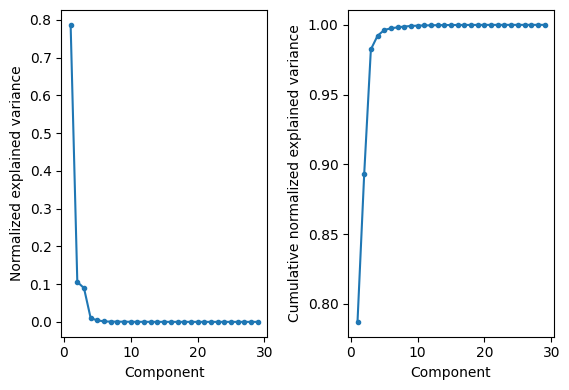

How many PCs (90 and 99% explained variance at component n3 and n4)? 4


In [2]:
hmp_data = hmp.utils.transform_data(epoch_data)

In this case we see that 99% explained variance is achieved with 4 PCs, and that this is coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with more PCs, but the elbow might occur before).

In [3]:
print(hmp_data)

<xarray.DataArray (component: 4, all_samples: 52641)>
array([[-0.10105472,  0.45274882,  0.49625417, ...,  2.66480049,
         1.89835533,  0.6146085 ],
       [ 0.12705575,  0.3131133 ,  0.31347984, ...,  1.81421013,
         0.79183619,  0.678829  ],
       [ 0.2633467 ,  0.20080037,  0.22488076, ...,  0.48586336,
        -0.08028338, -0.8341994 ],
       [ 0.07461077, -0.5516803 , -0.46542478, ...,  1.54882397,
         0.96906482,  0.41222519]])
Coordinates:
    stim         (all_samples) float64 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    resp         (all_samples) <U10 'resp_left' 'resp_left' ... 'resp_left'
    rt           (all_samples) float64 0.942 0.942 0.942 ... 0.376 0.376 0.376
    cue          (all_samples) <U2 'SP' 'SP' 'SP' 'SP' ... 'SP' 'SP' 'SP' 'SP'
    movement     (all_samples) <U10 'stim_right' 'stim_right' ... 'stim_left'
    trigger      (all_samples) <U24 'SP/stim_right/resp_left' ... 'SP/stim_le...
  * component    (component) int64 0 1 2 3
  * all_samples  

The data is now arranged as 4 PCs x 52641 samples: all trials of all participants were concatenated for the remainder of the analysis.

Finally, we need to initialize the model.

In [4]:
init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=cpus)

# Clustering

The first method that we will use to determine the number of events that are present in the data is clustering. We introduced this method in the previous tutorial:
- it first explores the space by sliding a single event across the trials, and stores solutions where the HMP estimation converges.
- we repeat this with different starting points on both parameters and magnitudes to get a better appreciation of the space.
- we can then cluster the discovered events to see how many there are.

As the first step, we test 81 models with different parameters and magnitudes (to test only a subset, use `decimate_grid`):

Number of potential magnitudes: 81


  0%|          | 0/81 [00:00<?, ?it/s]

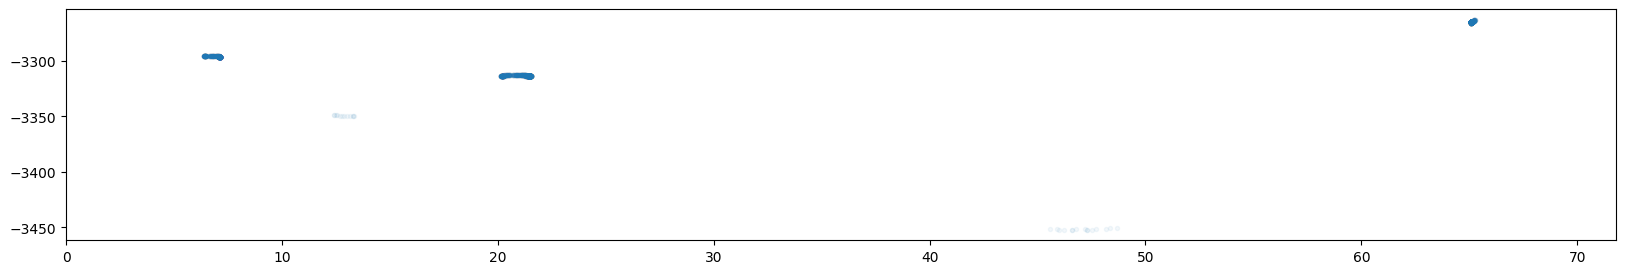

In [5]:
#calc estimates
lkhs, mags, channels, times = init.sliding_event_mags(epoch_data, step=3, decimate_grid= 1, cpu=cpus, plot=True, min_iteration=10)

The plot shows five clusters at different times, where the fourth one is weaker than the others, both in how often it was discovered and in likelihood. We store the likelihoods, times, topologies (channels), and magnitudes of all solutions.

Next, we use kmeans clustering, taking likelihood, time-of-occurence, and magnitudes into account. We also remove outliers based on the mahalanobis distance. The clustering method proposes a number of clusters based on the silhouette coefficients. If you agree with the solution (5) - as we do here - enter 0, if not, enter the number of clusters you would like to explore.

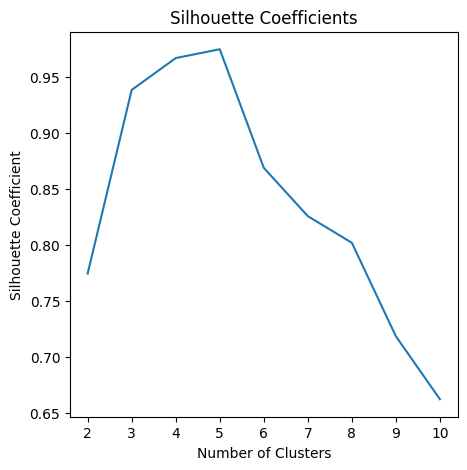

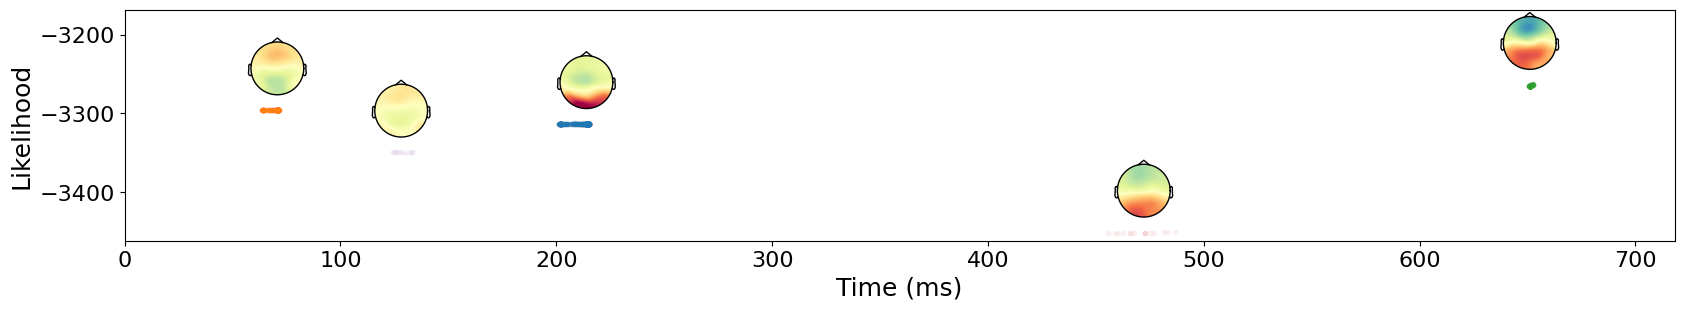

Do you agree with this solution [enter '0'], or would you like to explore a different number of clusters [enter the number of clusters]? 0


In [6]:
# cluster in time, lkh, and mags
mags_cl, pars_cl = hmp.clusters.cluster_events(init, lkhs, mags, channels, times, method='time_x_lkh_x_mags', max_clust=10, p_outlier=.05, info=info, calc_outliers=True)

Finally, we fit the selected model using the magnitudes and parameters of the clustering as input:

Estimating 5 events model
parameters estimated for 5 events model


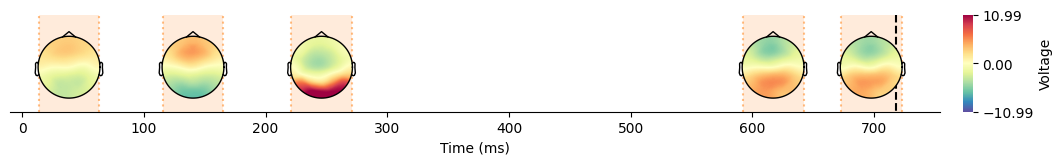

In [7]:
#fit final model
best_estimate = init.fit_single(mags_cl.shape[0], magnitudes=mags_cl,parameters=pars_cl)
hmp.visu.plot_topo_timecourse(epoch_data, best_estimate, info, init, magnify=1, sensors=False, contours=0, event_lines=True, colorbar=True, as_time=True)

As you can see, the solution is a bit different from the results of the clustering method itself, because now it estimates five events simultaneously. To counter this problem, we developed the fit() method, also introduced in the previous tutorial. In the next section we will combine it with leave-one-out-cross validation to discover the number of events we have evidence for.

### Exercise 1:

Test what different decimations of the clustering method have for effect, by adapting the code below.

In [ ]:
#estimate models
lkhs, mags, channels, times = init.sliding_event_mags(epoch_data, step=3, decimate_grid= XYZ, cpu=cpus, plot=True, min_iteration=10)

mags_cl, pars_cl = hmp.clusters.cluster_events(init, lkhs, mags, channels, times, method='time_x_lkh_x_mags', max_clust=10, p_outlier=.05, info=info, calc_outliers=True)

# Leave-one-out-cross validation (LOOCV)

The cluster method gave us an initial idea of which events occur in our data. Now we want to test statistically to what extent the different events generalize across subjects.

To start, we use the `fit` method to calculate the 'maximum solution' – it will find all likely events in the data. As introduced in Tutorial 2, the ```fit``` function slides potential events from 0 to mean RT. When an event is found – the Expectation Maximization estimation converges – one event is added to the model and the slide continues. This way we can detect new events while accounting for the previous ones. 

  0%|          | 0/72 [00:00<?, ?it/s]

Transition event 1 found around sample 7
Transition event 2 found around sample 24
Transition event 3 found around sample 30
Transition event 4 found around sample 67
Estimating 4 events model
parameters estimated for 4 events model


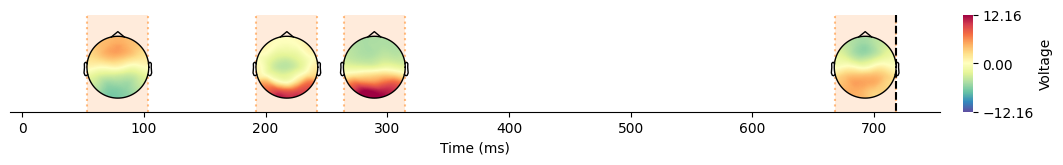

In [8]:
#estimate maximal model using fit
max_model = init.fit()
hmp.visu.plot_topo_timecourse(epoch_data, max_model, info, init, as_time=True,contours=0)

Here the `fit` method found four events – one less than with the clustering method. Next, we use `backward_estimation` – as introduced in the previous tutorial – to generate probable solutions with different numbers of events. We use the 'maximum solution' from the `fit` function as the starting point.

Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events


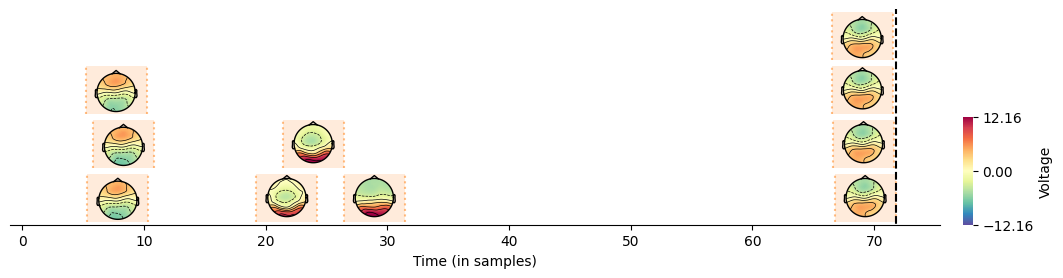

In [9]:
backward_model = init.backward_estimation(max_fit=max_model)
hmp.visu.plot_topo_timecourse(epoch_data, backward_model, info, init)

To determine which of the models really describes the data best, one might be inclined to look at the raw likelihood of the solutions:

Text(0.5, 0, 'N-event model')

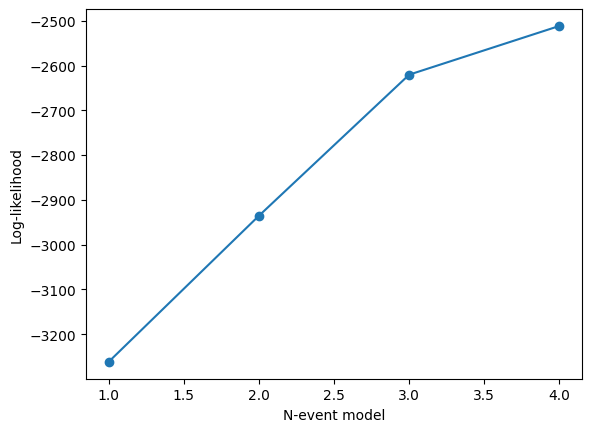

In [10]:
import matplotlib.pyplot as plt 

plt.plot(backward_model.n_events, backward_model.likelihoods,'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-event model')

Unfortunately, adding more parameters will almost always improve the fit (except when events start pushing each other away because of the defined minimum duration), here up to five events.

Hence we need a way to penalize the likelihood if solutions do not generalize to all participants. One way to do this is to perform leave-one out cross validation (LOOCV). This approach consists of fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters on the other participants. The function ```hmp.utils.loocv``` does exactly this. If we give it any model as input (including the results of backward estimation), it will fit models with the given model as starting points on _n-1_ participants and estimate the likelihood of the _nth_ participant, and repeat this for all _n_.

Note that LOOCV can be slow when there are many participants, in this case it might be worth it to add multiprocessing through the cpus parameter. However, this increases the memory use, so try to balance CPU use and memory depending on your situation.

In [11]:
loocv_model = hmp.utils.loocv(init, hmp_data, backward_model)


IMPORTANT:  This loocv procedure is incorrect in the sense that an initial estimate
is used to inform both the fit of the left-out participant and the other participants.
This means that they are not fully independent, unless the initial estimate is
based on the literature or another task. However, it does give a very good initial
idea of the correct loocv procedure and is relatively quick.

To do loocv correctly, use loocv_backward or the general loocv_func,
which calculate the initial estimate for every fold by applying
backward estimation or your own function, respectively.

LOOCV started for 1 model(s)
	LOOCV for backward estimation models with [4 3 2 1] event(s)
	  Estimating backward estimation model with 4 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 3 event(s)

We can then plot the result from the LOOCV procedure, with the likelihood per participant in the graph on the left, and the changes in likelihood on the right.

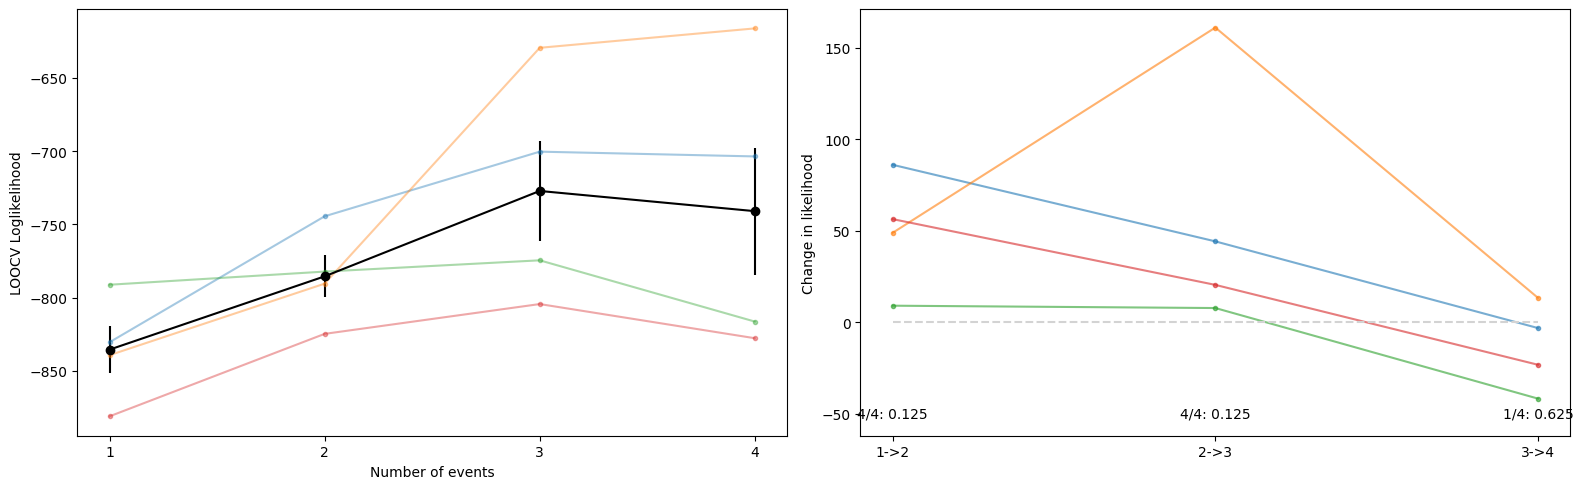

In [12]:
hmp.visu.plot_loocv(loocv_model, pvals=True, test='sign', indiv=True, mean=True) #Colored shaded lines represent individuals

Unlike in the graph above, the loglikelihood increases only up to 3 events, although with 4 participants the results are obviously not to be taken too seriously. The figure on the right contains p-values for sign tests evaluating whether the fit improved for a significant number of subjects, but this cannot be significant with 4 participants. In this case going to 3 events is the best option (see right panel), considering that it has the most events for which a significant number of participants improved (4/4). In normal-sized datasets, one can use the sign-test to see how many events generalize across subjects, and that is also typically done (see also [this paper](https://link.springer.com/article/10.1007/s42113-021-00105-2) for further discussion on this topic).

We can now plot the final model:

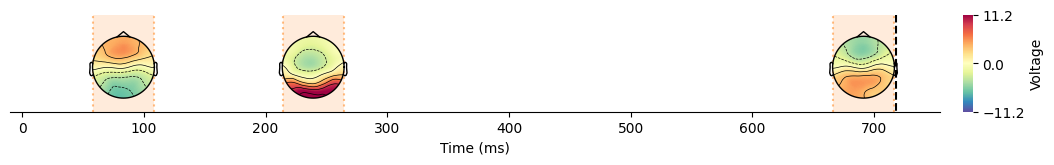

In [15]:
final_model = backward_model.sel(n_events=3)
hmp.visu.plot_topo_timecourse(epoch_data, final_model, info, init, as_time=True)

This method is therefore clearly more conservative than the clustering method (and than the maximal model from `fit`), at least with so few participants.

You might have noticed that the `loocv` method printed a warning saying that it is incorrect. The reason for this is that the input model is used to inform the models fitted to _n-1_ participants, while this input model was based on all participants. Therefore, the calculated loglikelihood of the _nth_ subject is not completely independent of the other participants. We do provide this function, because it a) provides a quick way to estimating rough LOOCV values and b) can be used if you have independent starting points, perhaps from the literature or other studies in your lab.

Of course, we also included a correct method. `loocv_func` will apply a given function (for example, backward estimation) to _n-1_ participants, and then calculate the fit. Unforunately, as in this case we don't have useful starting points it will take much longer to calculate. As we typically do this for backward estimation, we also provide a function specifically for this: `loocv_backward`. In the next tutorial we will illustrate how it can be used in a more complex situation (backward estimation followed by condition-specific models). Both `loocv_func` and `loocv_backward` return a list: the first item contains the loglikelihoods, the second item the fitted models to _n-1_ participants that can be used to construct the final model.

Executing the code below will take quite some time!

Calculating estimates with func <function backward_func at 0x7f4e843d3560> and args [4, 0, 1, 'random', 0.0001, True, 1000.0].
	Estimating model for all participants except processed_0025_epo
Estimating all solutions for maximal number of events (4) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
	Estimating model for all participants except processed_0023_epo
Estimating all solutions for maximal number of events (4) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
	Estimating model for all participants except processed_0024_epo
Estimating all solutions for maximal number of events (4) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions fo

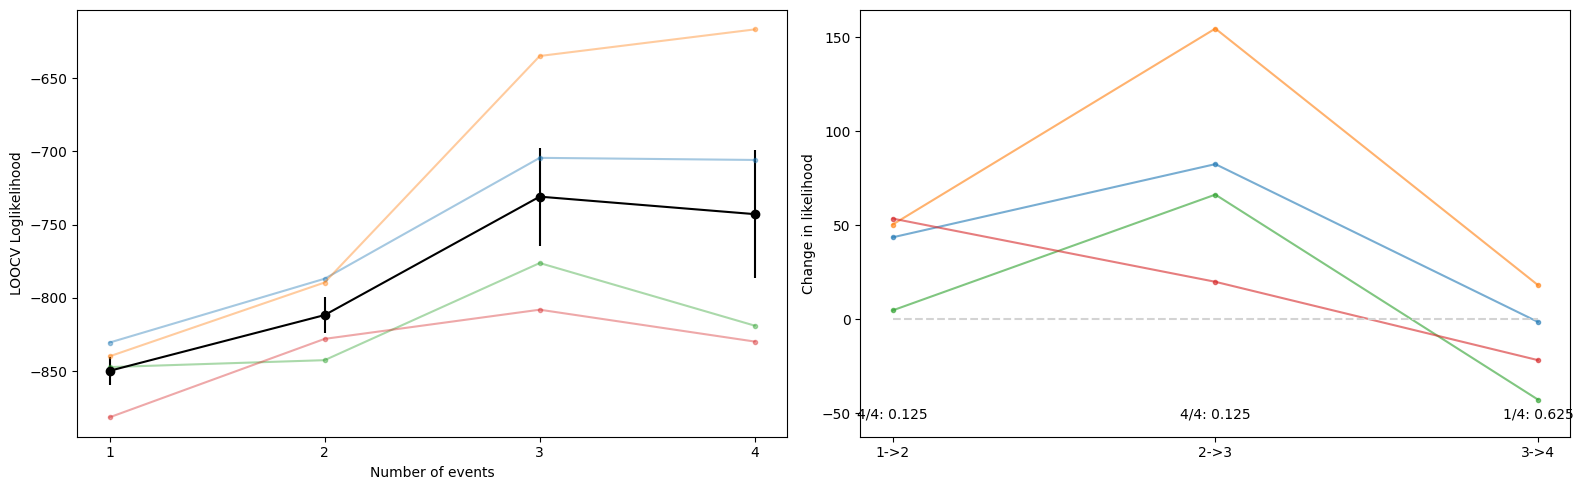

In [14]:
correct_loocv_model = hmp.utils.loocv_backward(init, hmp_data, max_events=4)
hmp.visu.plot_loocv(correct_loocv_model[0], pvals=True, test='sign', indiv=True, mean=True)

Not only are these results correct, but they are also smoother than the ones before. Now, we might go for a four event model, as 3 out of 4 participants still improved. However, we certainly have evidence for 3 events here.

Estimating 3 events model
parameters estimated for 3 events model


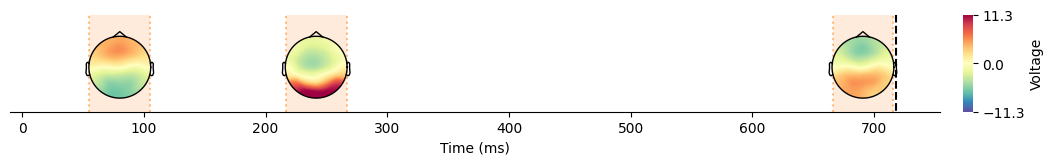

In [15]:
models = correct_loocv_model[1]

#get average mags and params
mags = models[0].sel(n_events=3).dropna('event').magnitudes
params = models[0].sel(n_events=3).dropna('stage').parameters
for pp in range(1,len(np.unique(models[0].participant.values))):
    mags += models[pp].sel(n_events=3).dropna('event').magnitudes
    params += models[pp].sel(n_events=3).dropna('stage').parameters
mags = mags / len(np.unique(models[0].participant.values))
params = params / len(np.unique(models[0].participant.values))

#fit final model
correct_final_model = init.fit_single(3,magnitudes=mags,parameters=params)
hmp.visu.plot_topo_timecourse(epoch_data, correct_final_model, info, init, as_time=True, contours=0)

... which is, as expected, very similar to the one above.

### Exercise 2:

The `loocv` method can deal with any model as input. Fit a 3-event and a 4-event model on all data with `fit_single`, and use them as input to `loocv`. Then, compare the likelihoods of the four participants to see which participants improve when adding one event.

In [ ]:
#fit models with three and four events
model3 = ...
model4 = ...

#perform loocv
loocv = hmp.utils.loocv(...,  [model3, model4], print_warning=False)

#explore likelihoods
loocv

### Exercise 3 (bonus):

If you feel adventurous, you can repeat Exercise 2, but now do it correctly with `hpm.utils.loocv_func`. Check its docstring to see how it can be used, and use `hmp.utils.example_fit_single_func` as your input function.

# Bootstrapping

At this point, we are certain that there is evidence in the data for at least three events. As a final step of judging the quality of this solution and estimating variability in the data due to noise and different strategies, for example, we perform bootstrapping. The idea of [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is to test the model on random samples (with replacement) of our data, to make sure that the discovered events are robust.

In the case of EEG data we can bootstrap the epochs/trials of the EEG data. Thus, the analysis consists of three steps that are repeated a number of times:
1. generate a bootstrapped dataset
2. fit a model using `fit_single` in combination with the parameters and magnitudes of the winning LOOCV model
3. record the parameters of the fitted HMP model

With sufficient bootstrapped repetitions we will know wich events tend to be rare (e.g., outliers or different strategies) and what the variance in time and topologies are.

To illustrate, we first run a single repetition:

In [17]:
#use final model as input
bootstrapped = hmp.resample.bootstrapping(fit=correct_final_model, data=epoch_data, 
                                          dim=['epochs','participant'], n_iterations=1,
                                          init=init, cpus=cpus, pca_weights=hmp_data.pca_weights)

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/hmp/resample.py:26: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_dim_order = list(data.dims.keys())


  0%|          | 0/1 [00:00<?, ?it/s]

We then compare to the times of the final LOOCV model (the vertical lines in the plot):

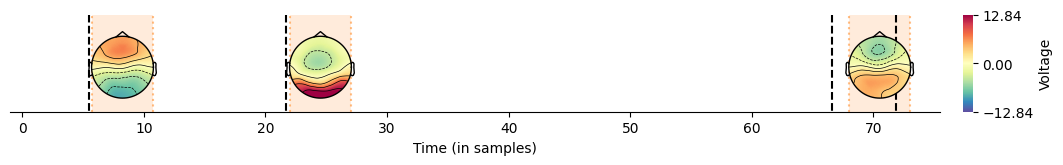

In [18]:
times_general_run = init.compute_times(init, correct_final_model, duration=False, mean=True, add_rt=True)
hmp.visu.plot_topo_timecourse(bootstrapped.sel(iteration=0).channels_activity.values, 
                              bootstrapped.sel(iteration=0).event_times.values,
                              info, init, times_to_display=times_general_run.values)

As you can see, hardly anything changes here. But one bootstrap is not very informative, so let's run 10 of them:

In [19]:
bootstrapped = hmp.resample.bootstrapping(fit=correct_final_model, data=epoch_data, 
                                          dim=['epochs','participant'], n_iterations=10,
                                          init=init, cpus=cpus, pca_weights=hmp_data.pca_weights)

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/hmp/resample.py:26: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_dim_order = list(data.dims.keys())


  0%|          | 0/10 [00:00<?, ?it/s]

We can then plot the bootstrapped models

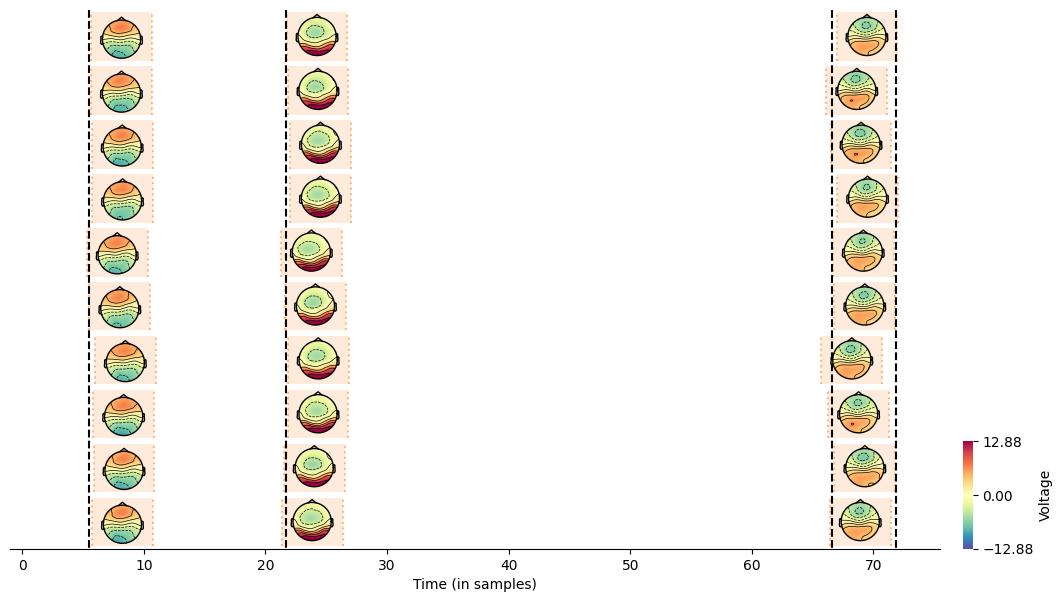

In [20]:
hmp.visu.plot_topo_timecourse(bootstrapped.channels_activity.values, 
                              bootstrapped.event_times.values,
                              info, init, times_to_display=times_general_run.values)

Only the last event shows some variability, this is clearly the hardest one to estimate.

### Exercise 4:

#### Exercise 4.1 on variability
The plot above shows mainly a change in the last event. What inference can you draw on this result?

The bootstrapped object contains all the bootstrapped run and we can use it to inspect different properties of the bootstrapped sample:

In [ ]:
print(bootstrapped.sel(event=[2]).event_times.std())
print(bootstrapped.sel(stage=[3]).parameters.prod(axis=1).std())

#### Exercise 4.2 how to spice your bootstraps

What dimension(s) can you think would be interesting to bootstrap on? What gives you the greatest differences?

In [ ]:
bootstrapped = hmp.resample.bootstrapping(fit=correct_final_model, data=epoch_data, 
                                          dim=['...'], n_iterations=10,
                                          init=init, cpus=cpus, pca_weights=hmp_data.pca_weights)
hmp.visu.plot_topo_timecourse(bootstrapped.channels_activity.values, 
                              bootstrapped.event_times.values,
                              info, init, times_to_display=times_general_run.values)

To summarize:
- we explored the likelihood landscape using the clustering method
- used LOOCV to determine statistically for how many events there is evidence in the data
- used bootstrapping to investigate the variability of the winning LOOCV model